In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s4e1/sample_submission.csv
/kaggle/input/playground-series-s4e1/train.csv
/kaggle/input/playground-series-s4e1/test.csv


In [2]:
X = pd.read_csv('/kaggle/input/playground-series-s4e1/train.csv')
y = X.Exited
X.drop(['Exited'],axis=1,inplace=True)
X.head(5)

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97
1,1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50
2,2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69
3,3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88
4,4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83


In [3]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165034 entries, 0 to 165033
Data columns (total 13 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   id               165034 non-null  int64  
 1   CustomerId       165034 non-null  int64  
 2   Surname          165034 non-null  object 
 3   CreditScore      165034 non-null  int64  
 4   Geography        165034 non-null  object 
 5   Gender           165034 non-null  object 
 6   Age              165034 non-null  float64
 7   Tenure           165034 non-null  int64  
 8   Balance          165034 non-null  float64
 9   NumOfProducts    165034 non-null  int64  
 10  HasCrCard        165034 non-null  float64
 11  IsActiveMember   165034 non-null  float64
 12  EstimatedSalary  165034 non-null  float64
dtypes: float64(5), int64(5), object(3)
memory usage: 16.4+ MB


In [4]:
X['Geography'].value_counts()

Geography
France     94215
Spain      36213
Germany    34606
Name: count, dtype: int64

In [5]:
X_drop = X.drop(['id','CustomerId','Surname'],axis=1)

In [6]:
from sklearn.preprocessing import OneHotEncoder
oh_G = OneHotEncoder(sparse_output = False)
ohe_Gender = oh_G.fit_transform(X_drop[['Gender']])
ohe_Gender_pd = pd.DataFrame(ohe_Gender, columns=[str(oh_G.categories_[0][i]) for i in range (len(oh_G.categories_[0]))])

oh_Gp = OneHotEncoder(sparse_output = False)
ohe_Geography = oh_Gp.fit_transform(X_drop[['Geography']])
ohe_Geography_pd = pd.DataFrame(ohe_Geography, columns=[str(oh_Gp.categories_[0][i]) for i in range (len(oh_Gp.categories_[0]))])

OH_X_drop = pd.concat([X_drop,ohe_Gender_pd,ohe_Geography_pd],axis=1)
OH_X_drop.drop(['Gender','Geography'],axis=1,inplace=True)

In [7]:
OH_X_drop.head(5)

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Female,Male,France,Germany,Spain
0,668,33.0,3,0.00,2,1.0,0.0,181449.97,0.0,1.0,1.0,0.0,0.0
1,627,33.0,1,0.00,2,1.0,1.0,49503.50,0.0,1.0,1.0,0.0,0.0
2,678,40.0,10,0.00,2,1.0,0.0,184866.69,0.0,1.0,1.0,0.0,0.0
3,581,34.0,2,148882.54,1,1.0,1.0,84560.88,0.0,1.0,1.0,0.0,0.0
4,716,33.0,5,0.00,2,1.0,1.0,15068.83,0.0,1.0,0.0,0.0,1.0


In [8]:
OH_X_drop.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165034 entries, 0 to 165033
Data columns (total 13 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   CreditScore      165034 non-null  int64  
 1   Age              165034 non-null  float64
 2   Tenure           165034 non-null  int64  
 3   Balance          165034 non-null  float64
 4   NumOfProducts    165034 non-null  int64  
 5   HasCrCard        165034 non-null  float64
 6   IsActiveMember   165034 non-null  float64
 7   EstimatedSalary  165034 non-null  float64
 8   Female           165034 non-null  float64
 9   Male             165034 non-null  float64
 10  France           165034 non-null  float64
 11  Germany          165034 non-null  float64
 12  Spain            165034 non-null  float64
dtypes: float64(10), int64(3)
memory usage: 16.4 MB


In [9]:
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score, roc_auc_score

def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test,pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('정확도: {0: .4f}, 정밀도: {1: .4f}, 재현율: {2: .4f},\
    F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy,precision,recall, f1, roc_auc))

In [10]:
from sklearn.model_selection import train_test_split
X_train,X_valid,y_train,y_valid = train_test_split(OH_X_drop,y,train_size=0.8,test_size=0.2,
                                                  random_state=0)

In [11]:
from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier(random_state=7)
dtc.fit(X_train,y_train)
preds = dtc.predict(X_valid)
pred_proba = dtc.predict_proba(X_valid)[:,1]
get_clf_eval(y_valid,preds,pred_proba)

정확도:  0.7994, 정밀도:  0.5209, 재현율:  0.5340,    F1: 0.5274, AUC:0.7021


-----------------------------------------------------------------

<Axes: >

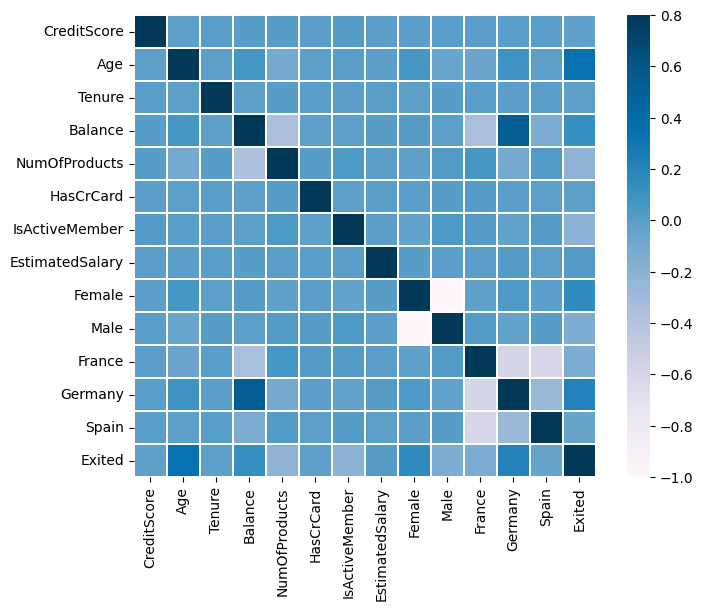

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

corr_data = pd.concat([OH_X_drop,y],axis=1)

colormap = plt.cm.PuBu
f, ax = plt.subplots(figsize = (8,6))
sns.heatmap(corr_data.corr(),square = True, linewidths = 0.1,
           cmap = colormap, linecolor = "white", vmax=0.8)

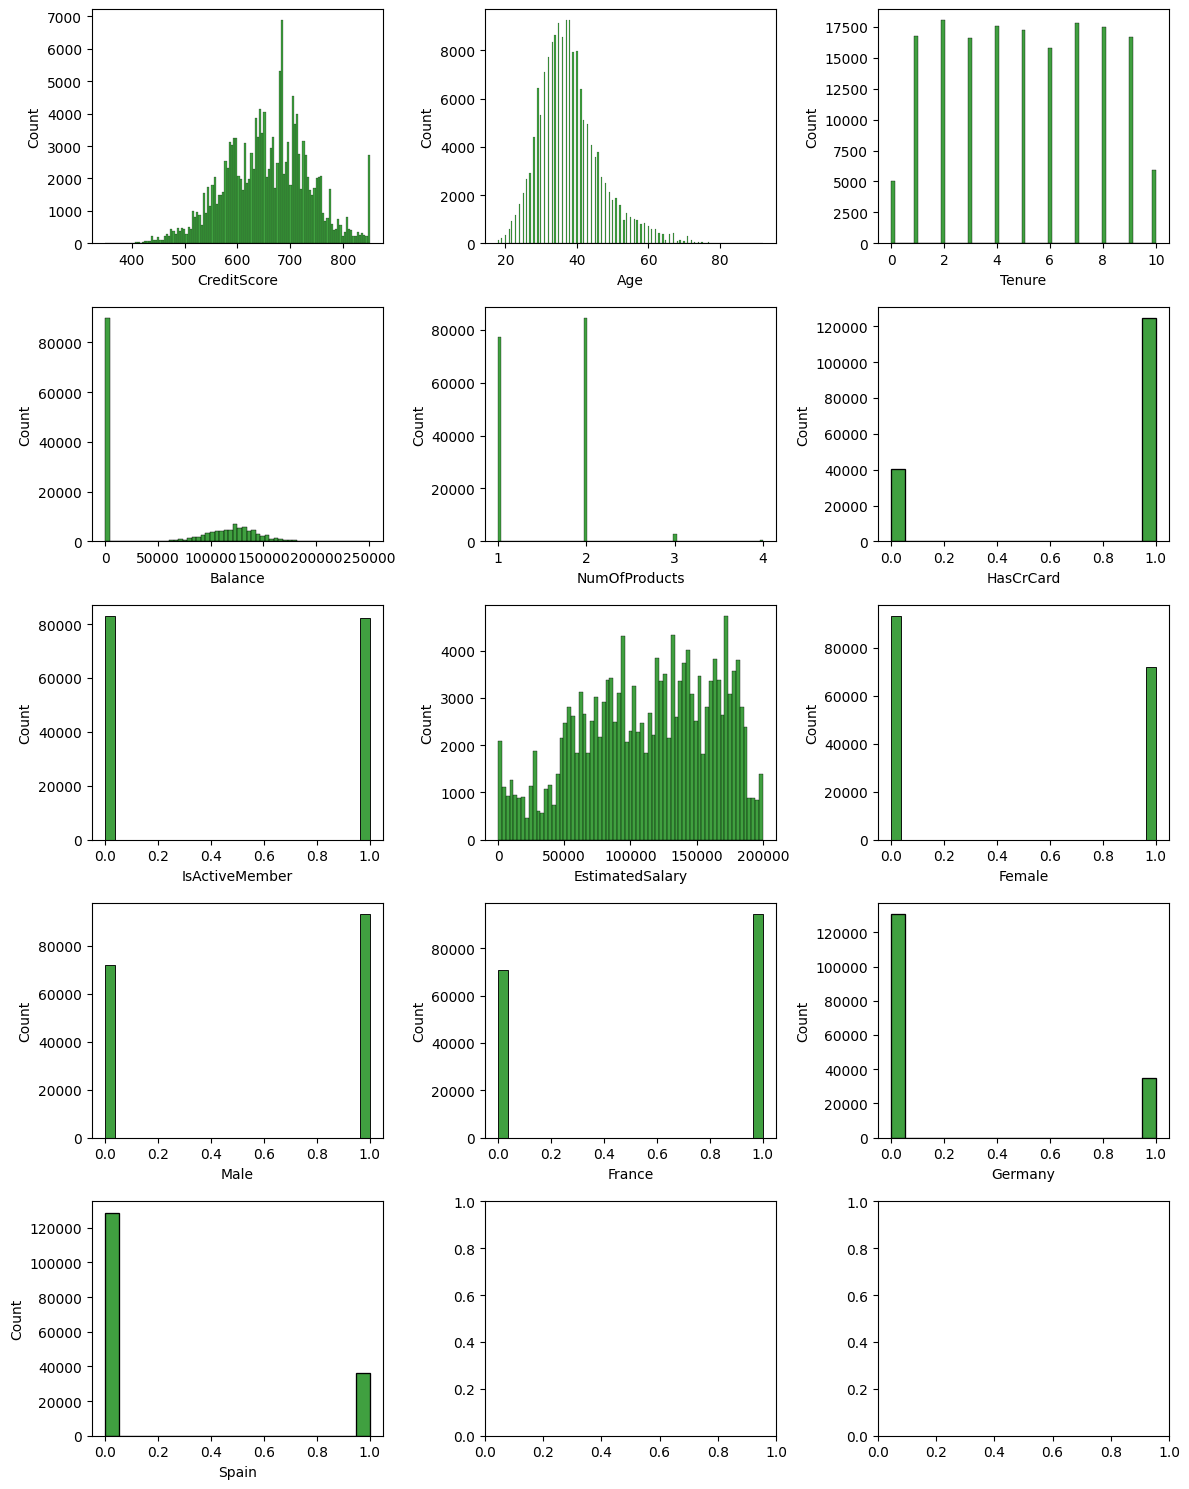

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

X_columns = OH_X_drop.columns
nr_rows = 5
nr_cols = 3
fig, axs = plt.subplots(nr_rows, nr_cols, figsize=(nr_cols*4,nr_rows*3))

for r in range(0,nr_rows):
    for c in range(0,nr_cols):
        i = r*nr_cols+c
        if i < len(X_columns):
            sns.histplot(OH_X_drop[X_columns[i]],color='green',ax = axs[r][c])
    
plt.tight_layout()
plt.show()

In [14]:
from scipy.stats import skew
skew(OH_X_drop[['EstimatedSalary']])

array([-0.30901873])

----------------------------------------------------
# Parameter tuning

In [15]:
from sklearn.model_selection import GridSearchCV

model = DecisionTreeClassifier(random_state=7)

param_grid = {
    'max_depth': [5, 10, 20, 30],
    'min_samples_split': [2,5,9],
    'min_samples_leaf': [2,4,6,8]
}

grid_search = GridSearchCV(model, param_grid, cv=5)
grid_search.fit(X_train, y_train)

print(grid_search.best_params_)

{'max_depth': 10, 'min_samples_leaf': 8, 'min_samples_split': 2}


In [16]:
best_model = DecisionTreeClassifier(random_state=7,**grid_search.best_params_)
best_model.fit(X_train,y_train)
preds = best_model.predict(X_valid)
pred_proba = best_model.predict_proba(X_valid)[:,1]
get_clf_eval(y_valid,preds,pred_proba)

정확도:  0.8591, 정밀도:  0.7141, 재현율:  0.5469,    F1: 0.6194, AUC:0.8772


------------------------------------------------------------------
# Submit

In [17]:
testData_original = pd.read_csv('/kaggle/input/playground-series-s4e1/test.csv')
testData = testData_original.drop(['id','CustomerId','Surname'],axis=1)

In [18]:
ohe_Gender = oh_G.transform(testData[['Gender']])
ohe_Gender_pd = pd.DataFrame(ohe_Gender, columns=[str(oh_G.categories_[0][i]) for i in range (len(oh_G.categories_[0]))])

ohe_Geography = oh_Gp.transform(testData[['Geography']])
ohe_Geography_pd = pd.DataFrame(ohe_Geography, columns=[str(oh_Gp.categories_[0][i]) for i in range (len(oh_Gp.categories_[0]))])

testData = pd.concat([testData,ohe_Gender_pd,ohe_Geography_pd],axis=1)
testData.drop(['Gender','Geography'],axis=1,inplace=True)

In [19]:
test_preds = best_model.predict(testData)
answer_df = pd.DataFrame(testData_original['id'],columns=['id'])
answer_df['Exited'] = test_preds
print(answer_df.head(5))

       id  Exited
0  165034       0
1  165035       1
2  165036       0
3  165037       0
4  165038       0


In [20]:
answer_df.to_csv('/kaggle/working/answer.csv',index=False)